In [64]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


here the objective is to fit the logit graph model to multiple different graph domains and then visualize the original vs fitted graphs

In [65]:

import sys
import os
sys.path.append('../')

#Graph imports
import src.graph as graph
import src.logit_estimator as estimator
import src.utils as utils
import src.model_selection as model_selection
import src.gic as gic
import src.param_estimator as pe
import src.graph as graph
import src.model_selection as ms

# usual imports
import matplotlib.pyplot as plt
import pickle
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx
from numpy import errstate

from IPython.display import display
from pyvis.network import Network
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [66]:
def load_facebook_graph(data_dir, graph_id):
    """
    Loads a Facebook graph from the specified directory and graph ID.

    Args:
        data_dir (str): The directory where the facebook data is stored.
        graph_id (int): The ID of the graph to load.

    Returns:
        networkx.Graph: The loaded graph as a networkx Graph object.
    """
    edge_file = os.path.join(data_dir, f"{graph_id}.edges")
    
    G = nx.Graph()
    
    with open(edge_file, 'r') as f:
        for line in f:
            # The files are space-separated, so we split the line
            # and convert the node IDs to integers.
            u, v = map(int, line.strip().split())
            G.add_edge(u, v)
            
    return G


data_directory = f'../data/misc/facebook'
ids = [0, 107, 348, 414, 686, 698, 1684, 1912, 3437, 3980]
graphs = []
for id in ids:
    graphs.append(load_facebook_graph(data_directory, id))
    print(f"Graph {id} loaded successfully. Edges: {graphs[-1].number_of_edges()}, Nodes: {graphs[-1].number_of_nodes()}")

Graph 0 loaded successfully. Edges: 2519, Nodes: 333
Graph 107 loaded successfully. Edges: 26749, Nodes: 1034
Graph 348 loaded successfully. Edges: 3192, Nodes: 224
Graph 414 loaded successfully. Edges: 1693, Nodes: 150
Graph 686 loaded successfully. Edges: 1656, Nodes: 168
Graph 698 loaded successfully. Edges: 270, Nodes: 61
Graph 1684 loaded successfully. Edges: 14024, Nodes: 786
Graph 1912 loaded successfully. Edges: 30025, Nodes: 747
Graph 3437 loaded successfully. Edges: 4813, Nodes: 534
Graph 3980 loaded successfully. Edges: 146, Nodes: 52


### Fitting single graph

Loading the different graphs into a networkx graph

In [38]:

def get_logit_graph(real_graph, d, n_iteration, warm_up, patience, dist_type='KL', edge_delta=None, min_gic_threshold=None, verbose=True):
   """
   Estimates parameters, generates a graph using the Logit Graph model,
   and calculates GIC, allowing for different convergence criteria.
   (This function is from your provided code)
   """
   if isinstance(real_graph, nx.Graph):
       real_graph = nx.to_numpy_array(real_graph)

   est = estimator.LogitRegEstimator(real_graph, d=d)
   features, labels = est.get_features_labels()
   result, params, pvalue = est.estimate_parameters(l1_wt=1, alpha=0, features=features, labels=labels)
   sigma = params[0]

   n = real_graph.shape[0]
   graph_model = graph.GraphModel(n=n, d=d, sigma=sigma)

   print(f"Running generation...")
   graphs, spec, spectrum_diffs, best_iteration, best_graph_arr = graph_model.populate_edges_spectrum_min_gic(
        max_iterations=n_iteration,
        patience=patience,
        real_graph=real_graph,
        edge_delta=edge_delta,
        min_gic_threshold=min_gic_threshold,
        gic_dist_type=dist_type,
        verbose=verbose,
    )
   print(f"Finished generation.")

   real_edges = np.sum(real_graph) / 2
   edge_diffs = [abs(np.sum(g) / 2 - real_edges) for g in graphs]

   best_graph_nx = nx.from_numpy_array(best_graph_arr)
   gic_value = gic.GraphInformationCriterion(
       graph=nx.from_numpy_array(real_graph),
       log_graph=best_graph_nx,
       model='LG',
       dist_type=dist_type
   ).calculate_gic()

   return best_graph_arr, sigma, [gic_value], spectrum_diffs, edge_diffs, best_iteration, graphs


def fit_single_logit_graph(original_graph, sim_params):
    """
    Fits a Logit Graph model to a single graph.

    Args:
        original_graph (nx.Graph): The original graph to fit.
        sim_params (dict): A dictionary of simulation parameters.

    Returns:
        tuple: A tuple containing:
            - nx.Graph: The fitted graph (or None if fitting failed).
            - dict: Metadata about the fitting process.
    """
    print(f"\n{'='*20} Processing Graph {'='*20}")
    print(f"Original graph - Nodes: {original_graph.number_of_nodes()}, Edges: {original_graph.number_of_edges()}")

    metadata = {
        'original_nodes': original_graph.number_of_nodes(),
        'original_edges': original_graph.number_of_edges(),
        'fit_success': False,
        'error_message': None,
    }
    
    try:
        adj_matrix = nx.to_numpy_array(original_graph)
        
        # Fit the model using the helper function
        best_graph_arr, sigma, gic_list, spectrum_diffs, edge_diffs, best_iteration, all_graphs = get_logit_graph(
            real_graph=adj_matrix,
            d=sim_params.get("d", 0),
            n_iteration=sim_params.get("n_iteration", 10000),
            warm_up=sim_params.get("warm_up", 500),
            patience=sim_params.get("patience", 2000),
            dist_type=sim_params.get("dist_type", 'KL'),
            edge_delta=sim_params.get("edge_delta", None),
            min_gic_threshold=sim_params.get("min_gic_threshold", 5),
            verbose=sim_params.get("verbose", True),
        )
        
        fitted_graph = nx.from_numpy_array(best_graph_arr)
        
        # Populate metadata on success
        metadata.update({
            'fit_success': True,
            'sigma': sigma,
            'gic_value': gic_list[0],
            'best_iteration': best_iteration,
            'fitted_nodes': fitted_graph.number_of_nodes(),
            'fitted_edges': fitted_graph.number_of_edges(),
            'spectrum_diffs': spectrum_diffs,
            'edge_diffs': edge_diffs,
        })
        
        print(f"Fitting successful - GIC: {metadata['gic_value']:.4f}, Best iteration: {metadata['best_iteration']}")
        print(f"Fitted graph - Nodes: {metadata['fitted_nodes']}, Edges: {metadata['fitted_edges']}")
        
        del all_graphs
        gc.collect()
        
        return fitted_graph, metadata

    except Exception as e:
        print(f"Error fitting graph: {e}")
        metadata['error_message'] = str(e)
        return None, metadata



In [39]:
# 1. Define simulation parameters
sim_params = {
    "d": 0,
    "n_iteration": 3000,
    "warm_up": 200,
    "patience": 200,
    "dist_type": 'KL',
    "min_gic_threshold": 5,
    "verbose": True,  # Set to True for more detailed output during fitting
}


# 2. Load or create an original graph
original_graph = graphs[0]

# 3. Fit the logit graph model
fitted_graph, metadata = fit_single_logit_graph(original_graph, sim_params)



==================== Processing Graph ====================
Original graph - Nodes: 333, Edges: 2519
Running generation...


Optimizing Graph:   0%|          | 4/3000 [00:00<00:58, 51.53it/s, GIC=21.9299, Spectrum Diff=401.7337, Patience=0/200, Edges=0.0/2519.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 5)
	 Best Spectrum Diff: inf
	 Patience: 0/200
	 Current edges: 0.0 (Real edges: 2519.0)


Optimizing Graph:  34%|███▎      | 1009/3000 [00:25<00:43, 45.27it/s, GIC=21.6914, Spectrum Diff=400.9744, Patience=0/200, Edges=2.0/2519.0]

iteration: 1000
	 Current GIC (KL): 21.6914 (Threshold: 5)
	 Best Spectrum Diff: 400.9744
	 Patience: 0/200
	 Current edges: 2.0 (Real edges: 2519.0)


Optimizing Graph:  67%|██████▋   | 2009/3000 [00:48<00:21, 45.53it/s, GIC=21.6805, Spectrum Diff=399.9156, Patience=0/200, Edges=5.0/2519.0]

iteration: 2000
	 Current GIC (KL): 21.6805 (Threshold: 5)
	 Best Spectrum Diff: 399.9156
	 Patience: 0/200
	 Current edges: 5.0 (Real edges: 2519.0)


Optimizing Graph: 100%|██████████| 3000/3000 [01:12<00:00, 41.29it/s, GIC=19.9424, Spectrum Diff=396.7757, Patience=0/200, Edges=15.0/2519.0]


iteration: 3000
	 Current GIC (KL): 19.9424 (Threshold: 5)
	 Best Spectrum Diff: 396.7757
	 Patience: 0/200
	 Current edges: 15.0 (Real edges: 2519.0)
Max iterations (3000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (3000) reached.

--- Results ---
- Best iteration found: 2982
- Best spectrum difference: 396.7757
- Edges in best graph: 15.0 (Real graph edges: 2519.0)
Finished generation.
Fitting successful - GIC: 19.9424, Best iteration: 2982
Fitted graph - Nodes: 333, Edges: 15


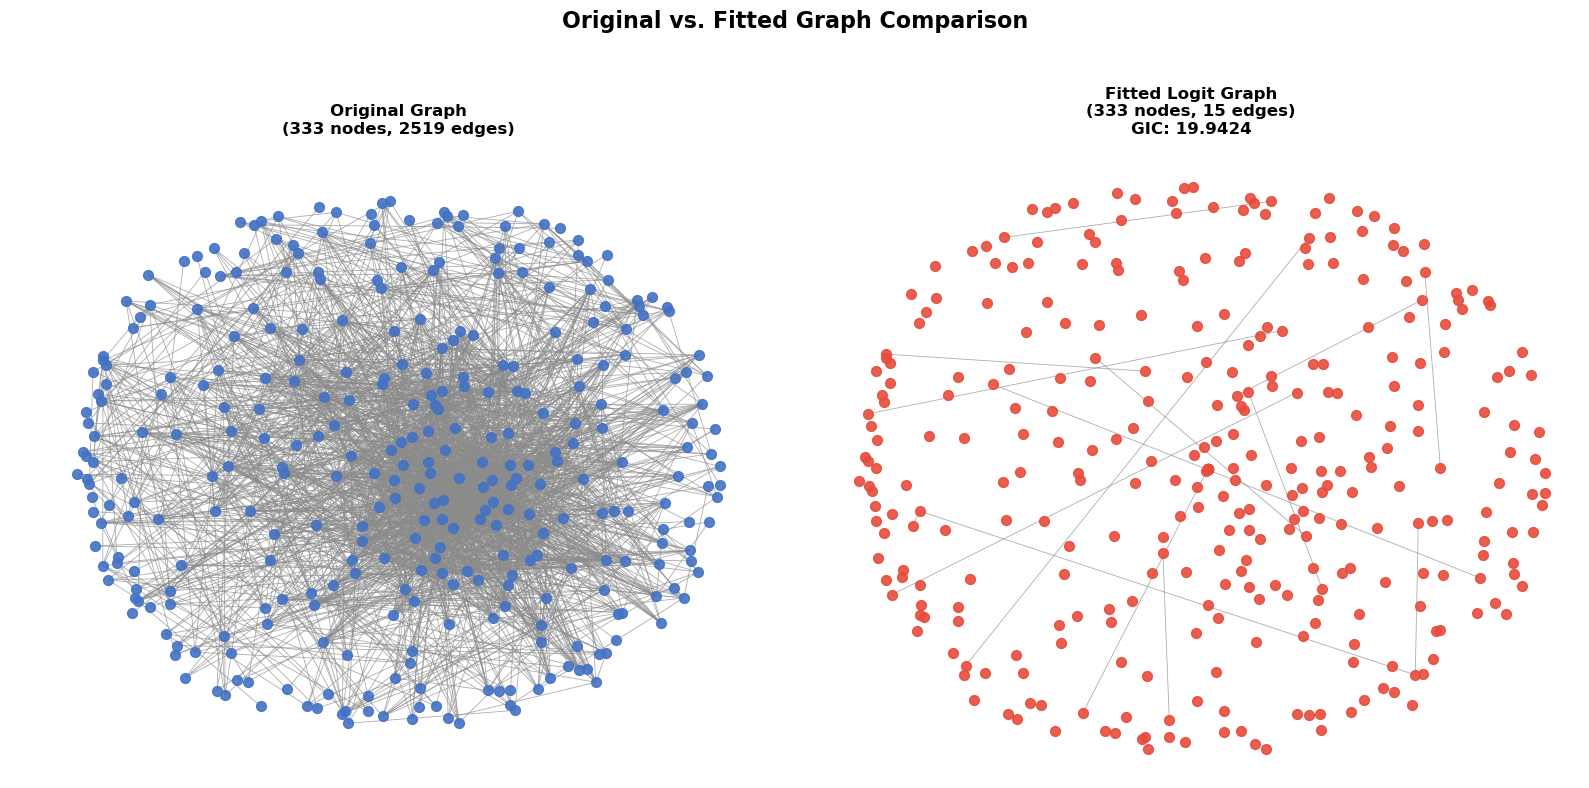

In [40]:
def compare_graphs_visually(original_graph, fitted_graph, metadata=None, figsize=(16, 8), node_size=50, edge_width=0.6):
    """
    Generates a side-by-side plot of the original and fitted graphs.

    Args:
        original_graph (nx.Graph): The original graph.
        fitted_graph (nx.Graph): The fitted graph (can be None if fitting failed).
        metadata (dict, optional): Fitting metadata to display in titles.
        figsize (tuple): The size of the matplotlib figure.
        node_size (int): The size of the nodes in the plot.
        edge_width (float): The width of the edges in the plot.

    Returns:
        matplotlib.figure.Figure: The figure object for the plot.
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Define colors and use a consistent layout for better comparison
    original_node_color = '#4472C4'
    fitted_node_color = '#E74C3C'
    edge_color = '#8B8B8B'
    pos = nx.spring_layout(original_graph, k=1, iterations=50, seed=42)
    
    # 1. Plot Original Graph
    ax_orig = axes[0]
    stats_orig = f"{original_graph.number_of_nodes()} nodes, {original_graph.number_of_edges()} edges"
    nx.draw_networkx_edges(original_graph, pos, ax=ax_orig, edge_color=edge_color, width=edge_width, alpha=0.7)
    nx.draw_networkx_nodes(original_graph, pos, ax=ax_orig, node_color=original_node_color, node_size=node_size, alpha=0.9)
    ax_orig.set_title(f'Original Graph\n({stats_orig})', fontweight='bold', pad=10)
    ax_orig.axis('off')

    # 2. Plot Fitted Graph
    ax_fitted = axes[1]
    title = 'Fitted Logit Graph'
    if fitted_graph and metadata and metadata.get('fit_success'):
        stats_fitted = f"{fitted_graph.number_of_nodes()} nodes, {fitted_graph.number_of_edges()} edges"
        gic_val = metadata.get('gic_value', 'N/A')
        gic_text = f"GIC: {gic_val:.4f}" if isinstance(gic_val, (int, float)) else f"GIC: {gic_val}"
        title = f'{title}\n({stats_fitted})\n{gic_text}'
        
        # Ensure the position dictionary is compatible with the fitted graph
        pos_fitted = {node: pos.get(node, (0, 0)) for node in fitted_graph.nodes}
        
        nx.draw_networkx_edges(fitted_graph, pos_fitted, ax=ax_fitted, edge_color=edge_color, width=edge_width, alpha=0.7)
        nx.draw_networkx_nodes(fitted_graph, pos_fitted, ax=ax_fitted, node_color=fitted_node_color, node_size=node_size, alpha=0.9)
    else:
        title = f'{title}\n(Fitting Failed)'
        ax_fitted.text(0.5, 0.5, 'Fitting Failed', horizontalalignment='center', verticalalignment='center', transform=ax_fitted.transAxes, fontsize=14, color='red')

    ax_fitted.set_title(title, fontweight='bold', pad=10)
    ax_fitted.axis('off')
    
    fig.suptitle('Original vs. Fitted Graph Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    return fig


# 5. Visualize the results
if metadata and metadata.get('fit_success'):
    comparison_figure = compare_graphs_visually(original_graph, fitted_graph, metadata)
    plt.show()
else:
    print("Fitting failed. No visualization available.")


In [41]:
print("\n--- Fitting Metadata ---")
if metadata['fit_success']:
    display(pd.Series(metadata).to_frame('Value'))
else:
    print(f"Fitting failed. Error: {metadata['error_message']}")



--- Fitting Metadata ---


,Value
original_nodes,333
original_edges,2519
fit_success,True
error_message,None
sigma,-5.0714
gic_value,19.9424
best_iteration,2982
fitted_nodes,333
fitted_edges,15
spectrum_diffs,"[401.73374267044073, 401.73374267044073, 401.7..."


### Comparison multiple families

Comparison logit graph with multiple other families

In [72]:
### Helper Functions (adapted from your code) ###

def get_logit_graph(real_graph, d, n_iteration, warm_up, patience, dist_type='KL', edge_delta=None, min_gic_threshold=None, verbose=True):
    """
    Estimates parameters and generates a graph using the Logit Graph model.
    """
    if isinstance(real_graph, nx.Graph):
        real_graph = nx.to_numpy_array(real_graph)

    est = estimator.LogitRegEstimator(real_graph, d=d)
    features, labels = est.get_features_labels()
    result, params, pvalue = est.estimate_parameters(l1_wt=1, alpha=0, features=features, labels=labels)
    sigma = params[0]

    n = real_graph.shape[0]
    graph_model = graph.GraphModel(n=n, d=d, sigma=sigma)

    if verbose:
        print(f"Running LG generation for d={d}...")
    
    graphs, spec, spectrum_diffs, best_iteration, best_graph_arr = graph_model.populate_edges_spectrum_min_gic(
        max_iterations=n_iteration,
        patience=patience,
        real_graph=real_graph,
        edge_delta=edge_delta,
        min_gic_threshold=min_gic_threshold,
        gic_dist_type=dist_type,
        verbose=verbose,
    )
    
    best_graph_nx = nx.from_numpy_array(best_graph_arr)
    gic_value = gic.GraphInformationCriterion(
        graph=nx.from_numpy_array(real_graph),
        log_graph=best_graph_nx,
        model='LG',
        dist_type=dist_type
    ).calculate_gic()

    return best_graph_arr, sigma, gic_value, best_iteration

def calculate_graph_attributes(graph_to_analyze):
    """Calculate various graph attributes for a given graph."""
    if graph_to_analyze is None or graph_to_analyze.number_of_nodes() == 0:
        return {attr: np.nan for attr in [
            'nodes', 'edges', 'density', 'avg_clustering', 'avg_path_length', 'diameter',
            'assortativity', 'num_components', 'largest_component_size'
        ]}
    
    attrs = {'nodes': graph_to_analyze.number_of_nodes(), 'edges': graph_to_analyze.number_of_edges()}
    
    try:
        attrs['density'] = nx.density(graph_to_analyze)
        attrs['avg_clustering'] = nx.average_clustering(graph_to_analyze)
        attrs['assortativity'] = nx.degree_assortativity_coefficient(graph_to_analyze)
        
        components = list(nx.connected_components(graph_to_analyze))
        attrs['num_components'] = len(components)
        if components:
            largest_cc = max(components, key=len)
            attrs['largest_component_size'] = len(largest_cc)
            subgraph = graph_to_analyze.subgraph(largest_cc)
            if len(largest_cc) > 1:
                attrs['avg_path_length'] = nx.average_shortest_path_length(subgraph)
                attrs['diameter'] = nx.diameter(subgraph)
            else:
                attrs['avg_path_length'] = 0
                attrs['diameter'] = 0
        else:
             attrs['largest_component_size'] = 0
             attrs['avg_path_length'] = np.nan
             attrs['diameter'] = np.nan
    
    except Exception as e:
        print(f"Could not calculate all attributes: {e}")

    return attrs

def clean_and_convert_param(param):
    """Clean and convert parameter string to float."""
    if isinstance(param, (int, float)):
        return param
    cleaned_param = ''.join(c for c in str(param) if c.isdigit() or c == '.' or c == '-')
    try:
        return float(cleaned_param)
    except (ValueError, TypeError):
        return np.nan


### Main Comparison Function ###

def compare_graph_models(original_graph, graph_filepath, sim_params):
    """
    Fit LG and other random graph models to a single graph and compare them.

    Args:
        original_graph (nx.Graph): The original graph to analyze.
        graph_filepath (str): The path to the original graph file for logging.
        sim_params (dict): Simulation parameters for Logit Graph and other models.

    Returns:
        tuple: A tuple containing:
            - pd.DataFrame: A summary of attributes and GIC for each model.
            - dict: A dictionary with the fitted graph objects and metadata for each model.
    """
    print(f"\n{'='*30} Processing Graph: {os.path.basename(graph_filepath)} {'='*30}")
    
    fitted_graphs_data = {
        'Original': {
            'graph': original_graph,
            'metadata': {'fit_success': True, 'param': 'N/A', 'gic_value': np.nan}
        }
    }
    adj_matrix = nx.to_numpy_array(original_graph)

    # 1. Fit Logit Graph (LG) model, finding the best `d`
    best_lg_fit = {'gic': np.inf}
    print("\n--- Fitting Logit Graph (LG) model ---")
    for d in sim_params["d_list"]:
        try:
            lg_arr, sigma, gic_val, best_iter = get_logit_graph(
                real_graph=adj_matrix, d=d, **sim_params['lg_params']
            )
            print(f"d={d}: GIC={gic_val:.4f}, sigma={sigma:.4f}")
            if gic_val < best_lg_fit['gic']:
                best_lg_fit = {
                    'gic': gic_val, 'graph': nx.from_numpy_array(lg_arr),
                    'param': f"d={d}, sigma={sigma:.4f}", 'sigma': sigma, 'best_iteration': best_iter
                }
        except Exception as e:
            print(f"Failed to fit LG for d={d}: {e}")

    if 'graph' in best_lg_fit:
        fitted_graphs_data['LG'] = {
            'graph': best_lg_fit['graph'],
            'metadata': {'fit_success': True, 'param': best_lg_fit['param'], 'gic_value': best_lg_fit['gic']}
        }
        print(f"Best LG fit found with GIC: {best_lg_fit['gic']:.4f}")
    else:
        fitted_graphs_data['LG'] = { 'graph': None, 'metadata': {'fit_success': False, 'param': 'N/A', 'gic_value': np.inf}}
        print("LG fitting failed for all values of d.")

    # 2. Fit other random graph models using GraphModelSelection
    print("\n--- Fitting other random graph models ---")
    
    # Use the best fitted LG graph for model selection if available
    lg_graph_for_selection = fitted_graphs_data['LG']['graph'] if fitted_graphs_data['LG']['metadata']['fit_success'] else original_graph
    lg_param_for_selection = best_lg_fit.get('sigma', 1.0)
    
    selector = ms.GraphModelSelection(
        graph=original_graph,
        log_graphs=[lg_graph_for_selection],
        log_params=[lg_param_for_selection],
        models=["ER", "WS", "GRG", "BA"],
        n_runs=sim_params.get("other_model_n_runs", 5),
        parameters=sim_params.get("other_model_params", [])
    )
    
    model_results = selector.select_model_avg_spectrum()

    for estimate in model_results['estimates']:
        model_name = estimate['model']
        if model_name != 'LG':
            param = clean_and_convert_param(estimate['param'])
            gic_value = estimate['GIC']
            
            func = selector.model_function(model_name=model_name)
            fitted_graph = func(original_graph.number_of_nodes(), param)
            
            fitted_graphs_data[model_name] = {
                'graph': fitted_graph,
                'metadata': {'fit_success': True, 'param': param, 'gic_value': gic_value}
            }
            print(f"{model_name} fitting - GIC: {gic_value:.4f}, Param: {param:.4f}")

    # 3. Calculate attributes and build the summary DataFrame
    print("\n--- Calculating graph attributes ---")
    df_rows = []
    for model_name, data in fitted_graphs_data.items():
        row = {'graph_filename': os.path.basename(graph_filepath), 'model': model_name}
        row.update(data['metadata'])
        
        attributes = calculate_graph_attributes(data['graph'])
        data['attributes'] = attributes # Store attributes in the results dict
        row.update(attributes)
        
        df_rows.append(row)
        
    summary_df = pd.DataFrame(df_rows)
    cols = ['graph_filename', 'model', 'gic_value', 'param', 'fit_success', 
            'nodes', 'edges', 'density', 'avg_clustering', 'avg_path_length', 
            'diameter', 'assortativity', 'num_components', 'largest_component_size']
    
    # Ensure all columns exist
    for col in cols:
        if col not in summary_df.columns:
            summary_df[col] = np.nan
            
    return summary_df[cols], fitted_graphs_data



In [73]:
# Define simulation parameters
sim_params = {
    "d_list": [0, 1, 2],
    "lg_params": {
        "n_iteration": 8000,
        "warm_up": 500,
        "patience": 500,
        "dist_type": 'KL',
        "min_gic_threshold": 1,
        "edge_delta": 30,
        "verbose": True,
    },
    "other_model_n_runs": 5,
    "other_model_params": [
        {'lo': 0.01, 'hi': 0.2},  # ER (probability)
        {'k': {'lo': 2, 'hi': 6, 'step': 2}, 'p': {'lo': 0.01, 'hi': 0.2}},  # WS
        {'lo': 1, 'hi': 3},      # GRG (alpha)
        {'lo': 1, 'hi': 8},     # BA (m)
    ]
}

graph_files = []
for id in ids:
    graph_files.append(f'../data/misc/facebook/{id}.edges')
graph_files = sorted(graph_files, key=lambda file: nx.read_edgelist(file, nodetype=int).number_of_nodes())


In [74]:
graph_files

['../data/misc/facebook/3980.edges',
 '../data/misc/facebook/698.edges',
 '../data/misc/facebook/414.edges',
 '../data/misc/facebook/686.edges',
 '../data/misc/facebook/348.edges',
 '../data/misc/facebook/0.edges',
 '../data/misc/facebook/3437.edges',
 '../data/misc/facebook/1912.edges',
 '../data/misc/facebook/1684.edges',
 '../data/misc/facebook/107.edges']

In [77]:
summary_dfs_dataset = []
fitted_graphs_dataset = []

folder_name = 'runs/fitted_graphs_comparison_facebook2'
os.makedirs(folder_name, exist_ok=True)

for graph_file in graph_files:
    print(f"Loading graph from: {graph_file}")
    original_graph = nx.read_edgelist(graph_file, nodetype=int)

    if original_graph.number_of_nodes() <= 100:
        n_iteration = 4000
    elif original_graph.number_of_nodes() > 100 and original_graph.number_of_nodes() <= 300:
        n_iteration = 8000
    elif original_graph.number_of_nodes() > 300 and original_graph.number_of_nodes() <= 500:
        n_iteration = 12000
    elif original_graph.number_of_nodes() > 700:
        n_iteration = 17000
    else:
        pass

    sim_params['lg_params']['n_iteration'] = n_iteration

    # Run the comparison
    summary_df, fitted_graphs = compare_graph_models(original_graph, graph_file, sim_params)
    summary_dfs_dataset.append(summary_df)
    fitted_graphs_dataset.append(fitted_graphs)

    import pickle
    graph_name = graph_file.split('/')[-1].split('.')[0]
    with open(f'{folder_name}/fitted_graphs_{graph_name}.pkl', 'wb') as f:
        pickle.dump(fitted_graphs_dataset, f)
    with open(f'{folder_name}/summary_dfs_{graph_name}.pkl', 'wb') as f:
        pickle.dump(summary_dfs_dataset, f)

Loading graph from: ../data/misc/facebook/3980.edges

============================== Processing Graph: 3980.edges ==============================

--- Fitting Logit Graph (LG) model ---
Running LG generation for d=0...


iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/500
	 Current edges: 0.0 (Real edges: 146.0)



*** GIC threshold 1 reached at iteration 950 (GIC: 0.6435) ***
*** Starting convergence check based on spectrum difference (Patience: 500) ***

iteration: 1000
	 Best Spectrum Diff: 31.1454
	 Patience: 0/500
	 Current edges: 52.0 (Real edges: 146.0)



























































































































































































































Optimizing Graph:  31%|███       | 1230/4000 [00:06<00:13, 200.34it/s, GIC=0.6435, Spectrum Diff=4.6627, Patience=35/500, Edges=176.0/146.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 1194
- Best spectrum difference: 4.6627
- Edges in best graph: 147.0 (Real graph edges: 146.0)
d=0: GIC=1.8835, sigma=-4.6308
Running LG generation for d=1...


iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/500
	 Current edges: 0.0 (Real edges: 146.0)



*** GIC threshold 1 reached at iteration 167 (GIC: 0.9753) ***
*** Starting convergence check based on spectrum difference (Patience: 500) ***



Optimizing Graph:   6%|▌         | 237/4000 [00:01<00:15, 249.57it/s, GIC=0.9753, Spectrum Diff=24.5462, Patience=0/500, Edges=78.0/146.0]












































































































Optimizing Graph:   9%|▊         | 343/4000 [00:01<00:15, 230.82it/s, GIC=0.9753, Spectrum Diff=11.2246, Patience=31/500, Edges=176.0/146.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 311
- Best spectrum difference: 11.2246
- Edges in best graph: 148.0 (Real graph edges: 146.0)
d=1: GIC=0.6121, sigma=-4.3053
Running LG generation for d=2...
































Optimizing Graph:   1%|          | 26/4000 [00:00<00:28, 140.72it/s, GIC=21.0608, Spectrum Diff=53.1413, Patience=0/500, Edges=0.0/146.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/500
	 Current edges: 0.0 (Real edges: 146.0)



*** GIC threshold 1 reached at iteration 530 (GIC: 0.9636) ***
*** Starting convergence check based on spectrum difference (Patience: 500) ***










































































































Optimizing Graph:  18%|█▊        | 702/4000 [00:03<00:16, 200.84it/s, GIC=0.9636, Spectrum Diff=10.7730, Patience=35/500, Edges=176.0/146.0]


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 666
- Best spectrum difference: 10.7730
- Edges in best graph: 146.0 (Real graph edges: 146.0)
d=2: GIC=1.8533, sigma=-4.6030
Best LG fit found with GIC: 0.6121

--- Fitting other random graph models ---
Testing the selected model for ER
ER result: {'param': 0.1366666666666667, 'spectrum': array([0.03846154, 0.09803922, 0.64177979, 0.77790347, 0.85633484,
       0.83634992, 0.87518854, 0.71983409, 0.1561086 , 0.        ]), 'gic': 0.6626441766183635}
Testing the selected model for WS
WS result: {'param': [4, 0.2], 'spectrum': array([0.42760181, 0.40874811, 0.34992459, 0.38914027, 0.56447964,
       0.73906486, 0.77865762, 0.7775264 , 0.56485671, 0.        ]), 'gic': 0.5078834267623986}
Testing the selected model for GRG
GRG result: {'param': 1.0, 'spectrum': array([0.03846154, 0.        , 0.        , 0.        , 0.35030166,
   

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/500
	 Current edges: 0.0 (Real edges: 270.0)






































































































































































































































Optimizing Graph:  11%|█         | 422/4000 [00:19<00:16, 210.55it/s, GIC=10.0227, Spectrum Diff=78.7504, Patience=0/500, Edges=13.0/270.0]



















































































































































Optimizing Graph:   7%|▋         | 549/8000 [01:02<14:06,  8.80it/s, GIC=1.3018, Spectrum Diff=75.3857, Patience=0/500, Edges=21.0/270.0] 





























































































































































































































































































































































*** GIC threshold 1 reached at iteration 970 (GIC: 0.9236) ***
*** Starting convergence check based on spectrum difference (Patience: 500) ***

iteration: 1000
	 Best Spectrum Diff: 69.4674
	 Patience: 9/500
	 Current edges: 37.0 (Real edges: 270.0)


Optimizing Graph:  25%|██▌       | 1007/4000 [00:06<00:17, 166.78it/s, GIC=0.9236, Spectrum Diff=69.1153, Patience=6/500, Edges=38.0/270.0]
































































































































































































































































































































































































































































































Optimizing Graph:  37%|███▋      | 1472/4000 [00:08<00:13, 181.41it/s, GIC=0.9236, Spectrum Diff=10.7567, Patience=42/500, Edges=300.0/270.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph

Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 1429
- Best spectrum difference: 10.7567
- Edges in best graph: 266.0 (Real graph edges: 270.0)
d=0: GIC=1.5877, sigma=-4.4488
Running LG generation for d=1...


iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/500
	 Current edges: 0.0 (Real edges: 270.0)



Optimizing Graph:  10%|█         | 420/4000 [00:02<00:14, 241.73it/s, GIC=0.9003, Spectrum Diff=54.1871, Patience=0/500, Edges=90.0/270.0]


*** GIC threshold 1 reached at iteration 361 (GIC: 0.9003) ***
*** Starting convergence check based on spectrum difference (Patience: 500) ***



Optimizing Graph:  16%|█▋        | 658/4000 [00:03<00:16, 203.88it/s, GIC=0.9003, Spectrum Diff=18.1921, Patience=32/500, Edges=300.0/270.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 625
- Best spectrum difference: 18.1921
- Edges in best graph: 271.0 (Real graph edges: 270.0)
d=1: GIC=0.5663, sigma=-3.9149
Running LG generation for d=2...


iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/500
	 Current edges: 0.0 (Real edges: 270.0)


Optimizing Graph:   1%|          | 31/4000 [00:00<00:20, 195.34it/s, GIC=21.7260, Spectrum Diff=84.3528, Patience=0/500, Edges=1.0/270.0]


*** GIC threshold 1 reached at iteration 373 (GIC: 0.9094) ***
*** Starting convergence check based on spectrum difference (Patience: 500) ***



Optimizing Graph:  17%|█▋        | 670/4000 [00:03<00:17, 195.52it/s, GIC=0.9094, Spectrum Diff=16.1685, Patience=26/500, Edges=300.0/270.0]


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 643
- Best spectrum difference: 16.1685
- Edges in best graph: 279.0 (Real graph edges: 270.0)
d=2: GIC=1.5803, sigma=-3.7050
Best LG fit found with GIC: 0.5663

--- Fitting other random graph models ---
Testing the selected model for ER
ER result: {'param': 0.2, 'spectrum': array([0.        , 0.        , 0.25      , 0.95      , 1.16666667,
       1.2       , 1.06666667, 0.36666667, 0.        , 0.        ]), 'gic': 1.500145747911176}
Testing the selected model for WS
WS result: {'param': [4, 0.07333333333333333], 'spectrum': array([0.55901639, 0.32896175, 0.31229508, 0.29644809, 0.54289617,
       0.7726776 , 0.87185792, 0.97021858, 0.34562842, 0.        ]), 'gic': 0.3288130036062215}
Testing the selected model for GRG
GRG result: {'param': 1.0, 'spectrum': array([0.03278689, 0.        , 0.        , 0.        , 0.39754098,
   

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/500
	 Current edges: 0.0 (Real edges: 1693.0)


iteration: 1000
	 Current GIC (KL): 6.3775 (Threshold: 1)
	 Best Spectrum Diff: 319.6759
	 Patience: 0/500
	 Current edges: 17.0 (Real edges: 1693.0)


iteration: 2000
	 Current GIC (KL): 1.3575 (Threshold: 1)
	 Best Spectrum Diff: 308.2351
	 Patience: 0/500
	 Current edges: 62.0 (Real edges: 1693.0)



*** GIC threshold 1 reached at iteration 2280 (GIC: 0.9313) ***
*** Starting convergence check based on spectrum difference (Patience: 500) ***



iteration: 3000
	 Best Spectrum Diff: 224.4319
	 Patience: 1/500
	 Current edges: 492.0 (Real edges: 1693.0)


iteration: 4000
	 Best Spectrum Diff: 100.2672
	 Patience: 0/500
	 Current edges: 1412.0 (Real edges: 1693.0)


Optimizing Graph:  54%|█████▍    | 4357/8000 [00:44<00:36, 98.64it/s, GIC=0.9313, Spectrum Diff=83.1516, Patience=6/500, Edges=1723.0/1693.0] 
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 4350
- Best spectrum difference: 83.1516
- Edges in best graph: 1718.0 (Real graph edges: 1693.0)
d=0: GIC=1.4166, sigma=-4.4240
Running LG generation for d=1...


iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/500
	 Current edges: 0.0 (Real edges: 1693.0)



*** GIC threshold 1 reached at iteration 677 (GIC: 0.8927) ***
*** Starting convergence check based on spectrum difference (Patience: 500) ***



iteration: 1000
	 Best Spectrum Diff: 222.7899
	 Patience: 0/500
	 Current edges: 546.0 (Real edges: 1693.0)


iteration: 2000
	 Best Spectrum Diff: 101.4259
	 Patience: 1/500
	 Current edges: 1458.0 (Real edges: 1693.0)


Optimizing Graph:  29%|██▉       | 2309/8000 [00:21<00:54, 105.13it/s, GIC=0.8927, Spectrum Diff=87.3464, Patience=0/500, Edges=1723.0/1693.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 2308
- Best spectrum difference: 87.3464
- Edges in best graph: 1724.0 (Real graph edges: 1693.0)
d=1: GIC=1.0293, sigma=-3.5719
Running LG generation for d=2...


iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/500
	 Current edges: 0.0 (Real edges: 1693.0)



*** GIC threshold 1 reached at iteration 689 (GIC: 0.8860) ***
*** Starting convergence check based on spectrum difference (Patience: 500) ***



iteration: 1000
	 Best Spectrum Diff: 224.8573
	 Patience: 0/500
	 Current edges: 532.0 (Real edges: 1693.0)


iteration: 2000
	 Best Spectrum Diff: 105.0276
	 Patience: 1/500
	 Current edges: 1449.0 (Real edges: 1693.0)


Optimizing Graph:  29%|██▉       | 2329/8000 [00:21<00:53, 106.54it/s, GIC=0.8860, Spectrum Diff=92.2759, Patience=0/500, Edges=1723.0/1693.0]


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 2328
- Best spectrum difference: 92.2759
- Edges in best graph: 1724.0 (Real graph edges: 1693.0)
d=2: GIC=1.0189, sigma=-3.4258
Best LG fit found with GIC: 1.0189

--- Fitting other random graph models ---
Testing the selected model for ER
ER result: {'param': 0.2, 'spectrum': array([0.00666667, 0.        , 0.        , 0.6233557 , 1.8163311 ,
       1.82975391, 0.72389262, 0.        , 0.        , 0.        ]), 'gic': 0.9918848966366265}
Testing the selected model for WS
WS result: {'param': [4, 0.052222222222222225], 'spectrum': array([0.57718121, 0.32885906, 0.26845638, 0.2885906 , 0.45637584,
       0.89261745, 0.81879195, 1.12751678, 0.24161074, 0.        ]), 'gic': 0.7811157914772022}
Testing the selected model for GRG
GRG result: {'param': 1.0, 'spectrum': array([0.02666667, 0.        , 0.        , 0.        , 0.48733781

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/500
	 Current edges: 0.0 (Real edges: 1656.0)


iteration: 1000
	 Current GIC (KL): 22.4698 (Threshold: 1)
	 Best Spectrum Diff: 332.2077
	 Patience: 0/500
	 Current edges: 5.0 (Real edges: 1656.0)


Optimizing Graph:  13%|█▎        | 1019/8000 [00:12<01:20, 86.53it/s, GIC=22.4688, Spectrum Diff=331.8607, Patience=0/500, Edges=6.0/1656.0]

iteration: 2000
	 Current GIC (KL): 8.3256 (Threshold: 1)
	 Best Spectrum Diff: 328.2982
	 Patience: 0/500
	 Current edges: 16.0 (Real edges: 1656.0)


iteration: 3000
	 Current GIC (KL): 1.6728 (Threshold: 1)
	 Best Spectrum Diff: 320.3237
	 Patience: 0/500
	 Current edges: 42.0 (Real edges: 1656.0)



*** GIC threshold 1 reached at iteration 3554 (GIC: 0.9890) ***
*** Starting convergence check based on spectrum difference (Patience: 500) ***



iteration: 4000
	 Best Spectrum Diff: 285.9979
	 Patience: 1/500
	 Current edges: 182.0 (Real edges: 1656.0)


iteration: 5000
	 Best Spectrum Diff: 180.8944
	 Patience: 1/500
	 Current edges: 890.0 (Real edges: 1656.0)


Optimizing Graph:  74%|███████▎  | 5884/8000 [01:03<00:22, 93.12it/s, GIC=0.9890, Spectrum Diff=125.5204, Patience=33/500, Edges=1686.0/1656.0] 
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 5850
- Best spectrum difference: 125.5204
- Edges in best graph: 1661.0 (Real graph edges: 1656.0)
d=0: GIC=0.7799, sigma=-4.6952
Running LG generation for d=1...


iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/500
	 Current edges: 0.0 (Real edges: 1656.0)



*** GIC threshold 1 reached at iteration 943 (GIC: 0.9974) ***
*** Starting convergence check based on spectrum difference (Patience: 500) ***



iteration: 1000
	 Best Spectrum Diff: 286.8175
	 Patience: 0/500
	 Current edges: 211.0 (Real edges: 1656.0)


iteration: 2000
	 Best Spectrum Diff: 167.9522
	 Patience: 0/500
	 Current edges: 1147.0 (Real edges: 1656.0)


Optimizing Graph:  33%|███▎      | 2609/8000 [00:23<00:49, 108.75it/s, GIC=0.9974, Spectrum Diff=142.2841, Patience=27/500, Edges=1686.0/1656.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 2581
- Best spectrum difference: 142.2841
- Edges in best graph: 1664.0 (Real graph edges: 1656.0)
d=1: GIC=0.7731, sigma=-4.5694
Running LG generation for d=2...


iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/500
	 Current edges: 0.0 (Real edges: 1656.0)


iteration: 1000
	 Current GIC (KL): 22.4790 (Threshold: 1)
	 Best Spectrum Diff: 333.7927
	 Patience: 0/500
	 Current edges: 1.0 (Real edges: 1656.0)


iteration: 2000
	 Current GIC (KL): 22.4790 (Threshold: 1)
	 Best Spectrum Diff: 333.7927
	 Patience: 0/500
	 Current edges: 1.0 (Real edges: 1656.0)


Optimizing Graph:  25%|██▌       | 2021/8000 [00:24<01:12, 82.68it/s, GIC=22.4790, Spectrum Diff=333.7927, Patience=0/500, Edges=1.0/1656.0]

iteration: 3000
	 Current GIC (KL): 22.4790 (Threshold: 1)
	 Best Spectrum Diff: 333.3717
	 Patience: 0/500
	 Current edges: 1.0 (Real edges: 1656.0)


iteration: 4000
	 Current GIC (KL): 22.4790 (Threshold: 1)
	 Best Spectrum Diff: 333.3717
	 Patience: 0/500
	 Current edges: 1.0 (Real edges: 1656.0)


iteration: 5000
	 Current GIC (KL): 22.4726 (Threshold: 1)
	 Best Spectrum Diff: 332.9625
	 Patience: 0/500
	 Current edges: 3.0 (Real edges: 1656.0)


Optimizing Graph:  63%|██████▎   | 5019/8000 [00:59<00:36, 81.11it/s, GIC=22.4726, Spectrum Diff=332.9625, Patience=0/500, Edges=3.0/1656.0]

iteration: 6000
	 Current GIC (KL): 22.4710 (Threshold: 1)
	 Best Spectrum Diff: 332.5823
	 Patience: 0/500
	 Current edges: 4.0 (Real edges: 1656.0)


iteration: 7000
	 Current GIC (KL): 21.4126 (Threshold: 1)
	 Best Spectrum Diff: 331.7836
	 Patience: 0/500
	 Current edges: 6.0 (Real edges: 1656.0)


Optimizing Graph: 100%|██████████| 8000/8000 [01:37<00:00, 82.09it/s, GIC=21.4126, Spectrum Diff=331.7836, Patience=0/500, Edges=6.0/1656.0]


iteration: 8000
	 Current GIC (KL): 21.4126 (Threshold: 1)
	 Best Spectrum Diff: 331.7836
	 Patience: 0/500
	 Current edges: 6.0 (Real edges: 1656.0)
Max iterations (8000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (8000) reached.

--- Results ---
- Best iteration found: 6984
- Best spectrum difference: 331.7836
- Edges in best graph: 6.0 (Real graph edges: 1656.0)
d=2: GIC=21.4126, sigma=-7.3714
Best LG fit found with GIC: 0.7731

--- Fitting other random graph models ---
Testing the selected model for ER
ER result: {'param': 0.1788888888888889, 'spectrum': array([0.02380952, 0.        , 0.        , 0.66748646, 1.76397206,
       1.79975763, 0.74497434, 0.        , 0.        , 0.        ]), 'gic': 1.4524436021222222}
Testing the selected model for WS
WS result: {'param': [4, 0.11555555555555555], 'spectrum': array([0.51436413, 0.35881808, 0.31700884, 0.38277017, 0.55022099,
       0.71171942, 0.80143285, 0.9330268 , 0.41866267, 0.01197605]), 'gic': 0.5

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Loading graph from: ../data/misc/facebook/348.edges

============================== Processing Graph: 348.edges ==============================

--- Fitting Logit Graph (LG) model ---
Running LG generation for d=0...


iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/500
	 Current edges: 0.0 (Real edges: 3192.0)


iteration: 1000
	 Current GIC (KL): 7.3273 (Threshold: 1)
	 Best Spectrum Diff: 544.1572
	 Patience: 0/500
	 Current edges: 13.0 (Real edges: 3192.0)


iteration: 2000
	 Current GIC (KL): 5.0336 (Threshold: 1)
	 Best Spectrum Diff: 536.6291
	 Patience: 0/500
	 Current edges: 41.0 (Real edges: 3192.0)



*** GIC threshold 1 reached at iteration 2991 (GIC: 0.9914) ***
*** Starting convergence check based on spectrum difference (Patience: 500) ***

iteration: 3000
	 Best Spectrum Diff: 520.1819
	 Patience: 8/500
	 Current edges: 112.0 (Real edges: 3192.0)


iteration: 4000
	 Best Spectrum Diff: 463.6628
	 Patience: 0/500
	 Current edges: 416.0 (Real edges: 3192.0)


iteration: 5000
	 Best Spectrum Diff: 357.2572
	 Patience: 0/500
	 Current edges: 1268.0 (Real edges: 3192.0)


iteration: 6000
	 Best Spectrum Diff: 267.6724
	 Patience: 0/500
	 Current edges: 2197.0 (Real edges: 3192.0)


KeyboardInterrupt: 

In [56]:
# Print the results
print("\n\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)

# Set display options for better DataFrame printing
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

display(summary_df)




MODEL COMPARISON SUMMARY


,graph_filename,model,gic_value,param,fit_success,nodes,edges,density,avg_clustering,avg_path_length,diameter,assortativity,num_components,largest_component_size
0,3980.edges,Original,NaN,N/A,True,52,146,0.1101,0.4617,2.5666,5,0.1605,4,44
1,3980.edges,LG,0.5680,"d=1, sigma=-4.3053",True,52,159,0.1199,0.1467,2.3597,4,0.0297,1,52
2,3980.edges,WS,0.4905,60.1189,True,52,156,0.1176,0.1042,2.3529,4,-0.0002,1,52
3,3980.edges,ER,0.5900,0.0944,True,52,139,0.1048,0.0870,2.4691,5,-0.1869,1,52
4,3980.edges,BA,4.7562,6.0000,True,52,276,0.2081,0.3439,1.8793,3,-0.1633,1,52
5,3980.edges,GRG,13.2805,1.0000,True,52,1290,0.9729,0.9756,1.0271,2,-0.0612,1,52


In [ ]:
print("\n" + "="*80)
print("FITTED GRAPHS DATA DICTIONARY (METADATA)")
print("="*80)
for model, data in fitted_graphs.items():
    print(f"\n--- {model} ---")
    print(f"  Graph object: {'Yes' if data.get('graph') else 'No'}")
    print(f"  Metadata: {data.get('metadata')}")
    print(f"  Attributes: {data.get('attributes')}")



FITTED GRAPHS DATA DICTIONARY (METADATA)

--- Original ---
  Graph object: Yes
  Metadata: {'fit_success': True, 'param': 'N/A', 'gic_value': nan}
  Attributes: {'nodes': 52, 'edges': 146, 'density': 0.11010558069381599, 'avg_clustering': 0.46172685095196414, 'assortativity': 0.16045074690466643, 'num_components': 4, 'largest_component_size': 44, 'avg_path_length': 2.5665961945031714, 'diameter': 5}

--- LG ---
  Graph object: Yes
  Metadata: {'fit_success': True, 'param': 'd=1, sigma=-4.3053', 'gic_value': 0.56801698232794}
  Attributes: {'nodes': 52, 'edges': 159, 'density': 0.11990950226244344, 'avg_clustering': 0.1466529197298428, 'assortativity': 0.029732328087841178, 'num_components': 1, 'largest_component_size': 52, 'avg_path_length': 2.3597285067873304, 'diameter': 4}

--- WS ---
  Graph object: Yes
  Metadata: {'fit_success': True, 'param': 60.11888888888888, 'gic_value': 0.4904664740163152}
  Attributes: {'nodes': 52, 'edges': 156, 'density': 0.11764705882352941, 'avg_cluste